In [4]:
import pandas as pd
import os
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch.utils.data as data

from settings import INPUTS_PATH
from utils.data_utils import timeseries_train_test_split, create_rolling_window_ts

plt.style.use('ggplot')

In [5]:
df = pd.read_csv(os.path.join(INPUTS_PATH, 'mixed_freq_df.csv'))
df.set_index('date', inplace=True)

df.tail()

,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
date,,,,,,,,,,,,,
2021-08-01,0.003286,NaN,0.002744,-0.037037,0.007042,-0.001632,-0.001062,0.001018,0.003135,0.003824,0.055828,NaN,NaN
2021-09-01,0.002570,0.005709,0.004124,-0.096154,-0.014622,-0.009759,-0.016185,0.002431,0.002405,0.003465,-0.078443,0.023111,0.014297
2021-10-01,0.004383,NaN,0.009433,-0.021277,0.001290,0.012333,-0.001650,0.005992,0.004427,0.006487,0.042245,NaN,NaN
2021-11-01,0.001677,NaN,0.007791,-0.086957,0.081186,0.007375,-0.001950,0.005346,0.004803,0.006266,0.038717,NaN,NaN
2021-12-01,0.001338,0.016791,0.004705,-0.071429,0.014303,-0.001024,-0.002285,0.005501,0.004981,0.004476,0.097845,NaN,NaN


## RNN with Univariate Time Series

### Dataset

<Axes: xlabel='date'>

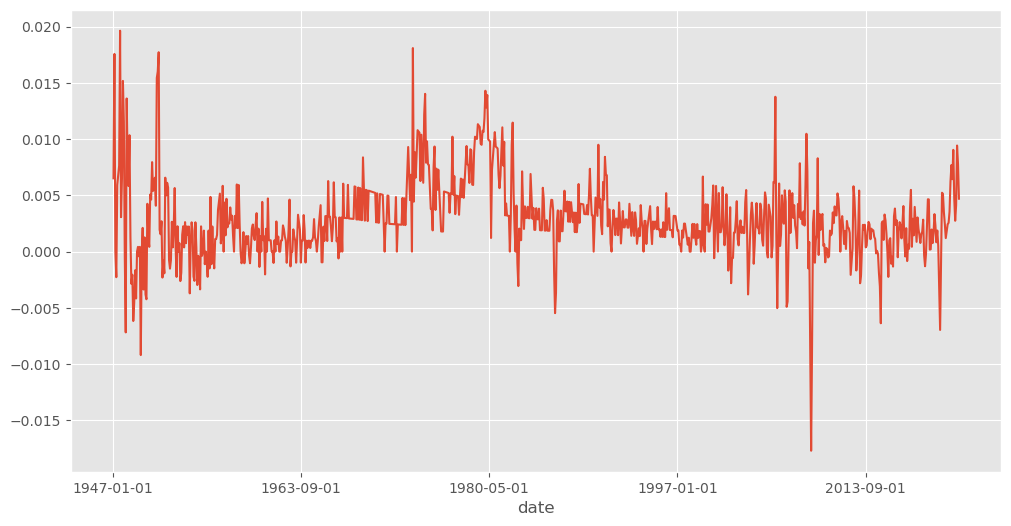

In [6]:
y = df["cpiaucsl"]

y.plot(figsize=(12, 6))

### Single pass of the RNN

In [7]:
input_size = 1
hidden_size = 10
num_layers = 1
batch_first = True

# dim: [num_batches, seq_len, input_size]
y_tensor = torch.tensor(df["cpiaucsl"].dropna().to_numpy())[None, :, None].to(torch.float32)

model = nn.RNN(input_size, hidden_size, num_layers, batch_first=batch_first)
linear = nn.Linear(hidden_size, input_size)

t = 0
y_t = y_tensor[:, 0:1, :]

b, T, d = y_t.shape

h0 = torch.randn(b, T, hidden_size)
o_t, h_t = model(y_t, h0)

y_t1 = linear(o_t)

### Multiple passes of the RNN

In [8]:
input_size = 1
hidden_size = 50
num_layers = 1
batch_first = True
fix_start = True
learning_rate = 0.01

target_df = df[["cpiaucsl"]].dropna()

# dim: [num_batches, seq_len, input_size]
y_tensor = torch.tensor(target_df.to_numpy())[None, :].to(torch.float32)
b, T, d = y_tensor.shape


class RNN(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 num_layers: int,
                 batch_first: bool=True) -> None:
        super().__init__()

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=batch_first, bias=False)
        self.linear = nn.Linear(hidden_size, input_size, bias=False)

    def forward(self,
                x: torch.Tensor,
                h0: torch.Tensor) -> torch.Tensor:
         # forward pass
        o_t, h_t = self.rnn(x, h0)

        # apply output to linear layer
        o_t = self.linear(o_t)

        return o_t, h_t

# model setup
model = RNN(input_size, hidden_size, num_layers, batch_first=batch_first)

# loss function
loss_fn = nn.MSELoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

preds = []
hiddens = []
losses = []
for t in tqdm(range(0, T-1), desc='Training RNN'):

    # random init for hidden state or use previous one
    if t == 0:
        h0 = torch.randn(num_layers, 1, hidden_size)
    else:
        h0 = h_t

    # train data
    y_t = y_tensor[:, t:(t+1), :]

    # test data
    y_true = y_tensor[:, (t+1):(t+2), :]

    y_t1, h_t = model(y_t, h0)
    h_t = h_t.detach()

    # apply loss function
    loss = loss_fn(y_t1, y_true)

    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()   

    # store predictions
    preds.append(y_t1.detach())

    # store hidden states
    hiddens.append(h_t.detach())

    # store loss
    losses.append(loss.detach().reshape(1, 1))
    
preds = torch.cat(preds, dim=1) 
hiddens = torch.cat(hiddens, dim=1)
losses = torch.cat(losses, dim=1)

Training RNN: 100%|██████████| 898/898 [00:00<00:00, 3705.20it/s]


Text(0.5, 1.0, 'CPI vs Predicted CPI')

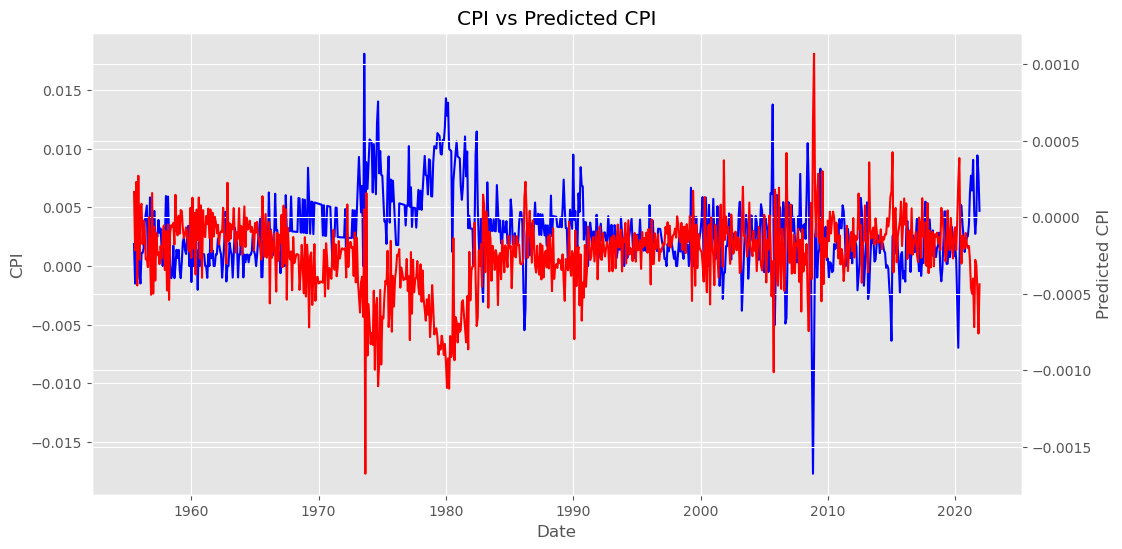

In [9]:
preds_df = pd.DataFrame(preds.numpy().squeeze()[100:], columns=["preds"], index=target_df.index[101:])
plot_df = pd.concat([target_df.iloc[101:, ], preds_df], axis=1)
plot_df.index = pd.to_datetime(plot_df.index)

# two y-axes plot and shared x-axis
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(plot_df["cpiaucsl"], color="blue")
ax2.plot(plot_df["preds"], color="red")
ax1.set_ylabel("CPI")
ax2.set_ylabel("Predicted CPI")
ax1.set_xlabel("Date")
plt.title("CPI vs Predicted CPI")

### Multiple passes of the RNN with batches and default hidden state

In [28]:
class RNN1(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 num_layers: int,
                 batch_first: bool=True) -> None:
        super().__init__()

        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=batch_first,
                          bias=True)
        self.linear = nn.Linear(in_features=hidden_size,
                                out_features=input_size,
                                bias=False)

    def forward(self,
                x: torch.Tensor,
                h0: torch.Tensor=None) -> torch.Tensor:
         # forward pass
        o_t, _ = self.rnn(x, h0)

        # apply output to linear layer
        o_t = self.linear(o_t)

        return o_t, _
    
input_size = 1
hidden_size = 50
num_layers = 1
batch_first = True
fix_start = False
learning_rate = 0.01
train_ratio = 0.8
epochs = 2000

num_timesteps_in = 12
num_timesteps_out = 1
train_shuffle = False
batch_size = 3
drop_last = True

target_df = df[["cpiaucsl"]].dropna()

# dim: [num_batches, seq_len, input_size]
y_tensor = torch.tensor(target_df.to_numpy()).to(torch.float32)
train_size = int(train_ratio * y_tensor.shape[0])
T = y_tensor.shape[0]

X_train, X_test, y_train, y_test = timeseries_train_test_split(X=y_tensor,
                                                                y=y_tensor,
                                                                train_ratio=train_ratio)

X_train, y_train = create_rolling_window_ts(target=y_train,
                                            features=X_train,
                                            num_timesteps_in=num_timesteps_in,
                                            num_timesteps_out=num_timesteps_out,
                                            fix_start=fix_start,
                                            drop_last=drop_last)

X_test, y_test = create_rolling_window_ts(target=y_test,
                                            features=X_test,
                                            num_timesteps_in=num_timesteps_in,
                                            num_timesteps_out=num_timesteps_out,
                                            fix_start=fix_start,
                                            drop_last=False)

train_loader = data.DataLoader(data.TensorDataset(X_train, y_train),
                                shuffle=train_shuffle,
                                batch_size=batch_size,
                                drop_last=drop_last)

In [30]:
X_train_batch.shape

torch.Size([3, 12, 1])

In [32]:
h_t.shape

torch.Size([1, 3, 50])

In [31]:
X_train.shape

torch.Size([706, 12, 1])

In [33]:
X_test.shape

torch.Size([168, 12, 1])

In [29]:
# model setup
model1 = RNN1(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first)

# loss function
loss_fn = nn.MSELoss()

# optimizer
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)

h_t = torch.zeros(num_layers, batch_size, hidden_size)
for i in tqdm(range(epochs), total=epochs, desc='Training RNN1'):
    for X_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()

        y_pred, h_t = model1(X_train_batch, h0=h_t)
        h_t = h_t.detach() 

        loss = loss_fn(y_pred, y_train_batch)
        loss.backward()
        optimizer.step()
    
    model1.eval()
    with torch.no_grad():

        h_t = nn.Linear()
        y_pred, h_t = model1(X_train, h_t)
        train_loss = loss_fn(y_pred, y_train)

        h_t = nn.Linear()
        y_pred, h_t = model1(X_test, h_t)
        test_loss = loss_fn(y_pred, y_test)

Training RNN1:   0%|          | 0/2000 [00:00<?, ?it/s]


RuntimeError: Expected hidden size (1, 706, 50), got [1, 3, 50]

In [9]:
with torch.no_grad():
    y_pred_train, _ = model1(X_train)
    y_pred_test, _ = model1(X_test)

    train_pred_df = pd.DataFrame(y_pred_train[:, -1, :].detach().numpy(), columns=["preds"], index=target_df.index[num_timesteps_in+1:train_size])
    test_pred_df = pd.DataFrame(y_pred_test[:, -1, :].detach().numpy(), columns=["preds"], index=target_df.index[(train_size + num_timesteps_in):T])
    pred_df = pd.concat([train_pred_df, test_pred_df], axis=0)

    pred_df = pd.concat([target_df.iloc[num_timesteps_in+1:, ], pred_df], axis=1)
    pred_df.index = pd.to_datetime(pred_df.index)

Text(0.5, 1.0, 'CPI vs Predicted CPI')

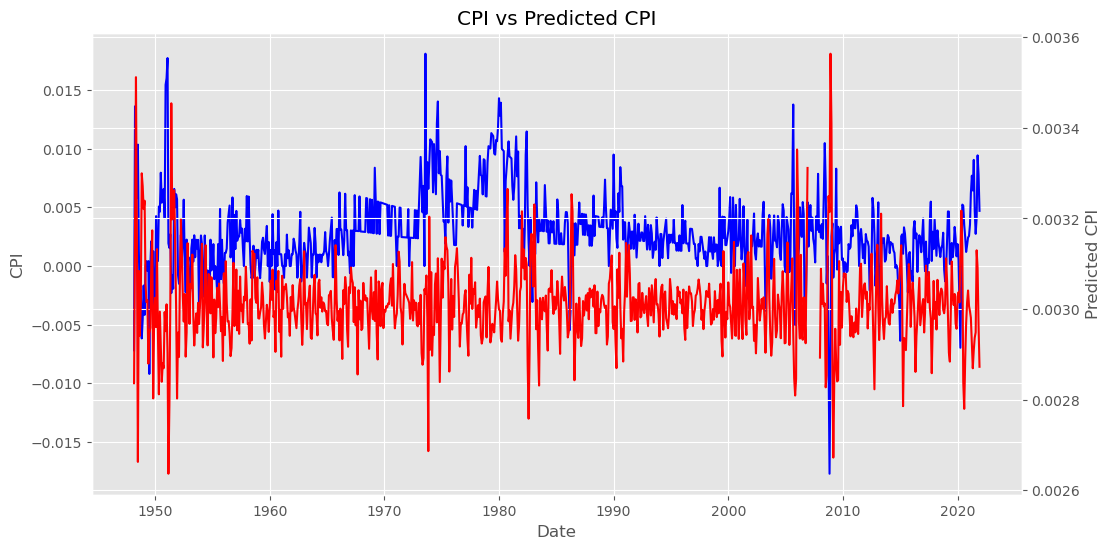

In [10]:
# two y-axes plot and shared x-axis
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(pred_df["cpiaucsl"], color="blue")
ax2.plot(pred_df["preds"], color="red")
ax1.set_ylabel("CPI")
ax2.set_ylabel("Predicted CPI")
ax1.set_xlabel("Date")
plt.title("CPI vs Predicted CPI")